<a href="https://colab.research.google.com/github/zhiyuan-95/Amex-default-prediction-/blob/main/portfolio_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
from pandas_datareader import data as pdr
import yfinance as yfin
from datetime import datetime, timedelta,date
import time
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from google.colab import drive

In [127]:
drive.mount('/content/drive')
yfin.pdr_override()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
file_path = '/content/drive/My Drive/Colab Notebooks/FEDFUNDS.csv'

In [129]:
class portfolio:
  def __init__(self,tickers):
    self._tickers = tickers
    self._div_history = pd.DataFrame()
    self._price_history = pd.DataFrame()
    self._t0 = ''
    self._period = 12
    self._t1 = ''
    self._price= pd.DataFrame()
    self._return = []
    self._div = pd.DataFrame()
    self._corr = 'numpy'
    self._mu = []
    self._fed_rate_history = ''
    self._fed_rate = 0
    self.get_stocks()
  def get_stocks(self):
      file_names = []
      temp = []
      div_date = []
      div_history = {}
      iter = 0
      Start = '2000-01-01'
      End = '2023-01-01'
      for x in self._tickers:
        self._price_history[x] = pdr.get_data_yahoo(x,start=Start, end=End)['Adj Close']
        div_history[x] = yfin.Ticker(x).dividends
        div_date+=list(div_history[x].index)
      div_date = sorted(div_date)
      self._div_history.index= map(lambda x: x.strftime('%Y-%m-%d'), div_date)
      for y in self._tickers:
        self._div_history[y] =div_history[y]
        self._div_history[y] = self._div_history[y].fillna(0)
      file_path = '/content/drive/My Drive/Colab Notebooks/FEDFUNDS.csv'
      fed_rate = pd.read_csv(file_path)
      self._fed_rate_history = fed_rate.loc[(fed_rate.DATE>Start) & (fed_rate.DATE<End)]
  def update(self, date):
    self._t1 = datetime.strptime(date,'%Y-%m-%d')
    self._t0 = self._t1-timedelta(weeks = self._period)
    start = self._t0.strftime('%Y-%m-%d')
    end = self._t1.strftime("%Y-%m-%d")
    last_year = str(int(end[:4])-1)
    self._price = self._price_history[start:end]
    self._div = self._div_history[self._div_history.index.str.startswith(last_year)].to_numpy()
    self._corr = self._price.corr().to_numpy()
    self._price = self._price.to_numpy()
    self._fed_rate = self._fed_rate_history[self._fed_rate_history.DATE>date]['FEDFUNDS'].iloc[0]/100
    self.Expected_return()
  def Return(self):
    # return  = return on stock value from t0-t1 + expected on dividend
    # expected return on dividend of period t of year n = sum of dividend of year n-1 *(t/52)
    p0 = self._price[0]
    p1 = self._price[1]
    return_p = (p1-p0)/p0
    div_rate = sum(self._div)/p0
    E_return_d = div_rate*self._period/52
    return return_p+E_return_d
  def pastReturn(self,years=3):
    rtn = np.empty((years,len(tickers)))
    for t in range(years):
      the_year = str(int(self._t1.strftime("%Y-%m-%d")[:4])-t-1)
      stock_last_yr= self._price_history[self._price_history.index.strftime("%Y-%m-%d").str.startswith(the_year)].to_numpy()
      div_sum = self._div_history[self._div_history.index.str.startswith(the_year)].to_numpy()
      rtn[t] = (sum(div_sum)+stock_last_yr[-1]-stock_last_yr[0])/stock_last_yr[0]
    return sum(rtn)/3
  def Expected_return(self,w = 0.8):
    self._mu = w*self.Return()+(1-w)*self.pastReturn()
  def negative_sharpe(self, weights):
    portfolio_return = np.dot(weights, self._mu)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(self._corr, weights)))
    sharpe_ratio = (portfolio_return - self._fed_rate) / portfolio_stddev
    return -sharpe_ratio
  def optimized_weights(self):
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    initial_weights = np.ones(len(self._mu)) / len(self._mu)
    # Perform the optimization
    bounds = tuple((0, 1) for _ in range(len(self._mu)))
    result = minimize(self.negative_sharpe, initial_weights,bounds=bounds, constraints=constraints)
    # Extract the optimized weights
    optimized_weights = result.x
    return np.round(optimized_weights, decimals = 2)

In [131]:
tickers = ['spy','qqq','tlt','iwm']
p = portfolio(tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [198]:
def sell(shares, price):
  return sum(shares*price)
def buy(investment,price,weight):
  return investment*weight/price
date = '2005-01-03'
asset = 100
number_of_shares = [0 for x in range(len(tickers))]
investment = [100]
invest_p = [asset for x in range(len(tickers))]
dates = []
org_share = []
track = []
for x in range(200):
  p.update(date)
  price = p._price[0]
  weight = p.optimized_weights()
  dates.append(date)
  if x==0:
    num_of_shares = buy(asset,price,weight)
    org_share = invest_p/price
    track.append(invest_p)
  else:
    asset = sell(num_of_shares,price)
    num_of_shares = buy(asset,price,weight)
    investment.append(asset)
    track.append((org_share*price))
  date= datetime.strptime(date,'%Y-%m-%d')
  t1 = date+timedelta(weeks = 4)
  date = t1.strftime('%Y-%m-%d')
#  print(date,weight,round(p._fed_rate,3))
PR = np.array(track)

In [199]:
PR

array([[100.        , 100.        , 100.        , 100.        ],
       [103.66468796, 106.29376763,  99.79500196, 104.30777054],
       [105.83632756, 112.64339559, 100.47888111, 110.33521695],
       [107.30855345, 111.54783635, 102.01102395, 111.36674099],
       [105.39962881, 105.61735995, 105.42527655, 108.24759477],
       [107.6028762 , 105.10906823, 103.87331157, 110.02498268],
       [105.0524191 , 102.62396764, 101.54902605, 106.90601559],
       [104.17484351,  99.91286908, 106.58433187, 103.66777749],
       [107.26434334, 106.88818876, 109.79953463, 106.7747518 ],
       [109.15387383, 107.04350288, 110.2044423 , 111.72061328],
       [110.00803264, 109.47438536, 109.52711321, 115.12414019],
       [111.32978869, 111.50956767, 109.69872784, 116.17679233],
       [111.80627653, 112.30100534, 110.41295767, 118.75582846],
       [107.09026238, 107.77837108, 108.98395087, 111.53440107],
       [110.36797097, 113.43158614, 105.4604108 , 115.65230015],
       [114.29582084, 118

In [200]:
years =list(map(lambda x: x[:4],dates))
year = sorted(list(set(years)))
position = []
for x in year:
  position.append(years.index(x))

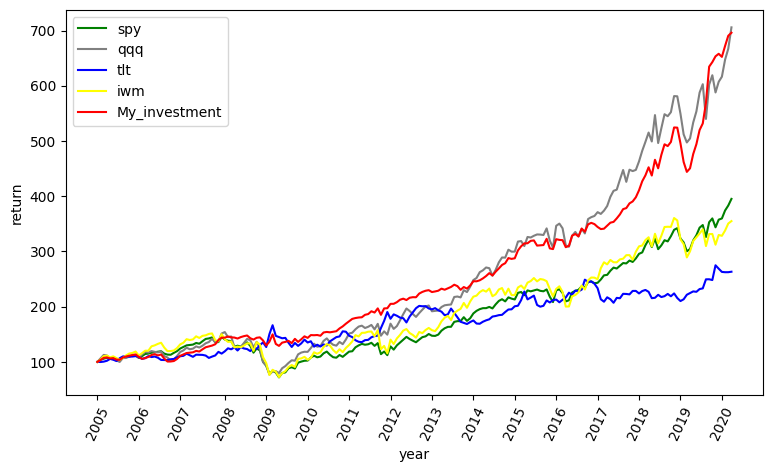

In [201]:
import matplotlib.pyplot as plt
fg, ax = plt.subplots(figsize = (9,5))
plt.xlabel('year', fontsize=10)
plt.ylabel('return', fontsize=10)
itr = 0
cr = ['green','gray','blue','yellow','red']
for x in range(len(tickers)):
  ax.plot(PR[:,x],label=tickers[x],color = cr[x])
ax.plot(investment,label='My_investment',color = 'red')
plt.xticks(position,year)
ax.xaxis.set_tick_params(rotation=65, labelsize=10)
ax.legend()